In [15]:
import math
import torch
import gpytorch
import tqdm

In [20]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 16, 1)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        if num_latents == num_tasks:
            variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self, inducing_points, variational_distribution, learn_inducing_locations=True
                ),
                num_tasks=num_tasks
            )
        else:
            variational_strategy = gpytorch.variational.LMCVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self, inducing_points, variational_distribution, learn_inducing_locations=True
                ),
                num_tasks=num_tasks,
                num_latents=num_latents
            )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [21]:
class MaskedMultitaskGaussianLikelihood(gpytorch.likelihoods.MultitaskGaussianLikelihood):
    def expected_log_prob(self, target, input, mask, *params, **kwargs):
        mean, variance = input.mean, input.variance
        num_event_dim = len(input.event_shape)

        noise = self._shaped_noise_covar(mean.shape, *params, **kwargs).diag()
        # Potentially reshape the noise to deal with the multitask case
        noise = noise.view(*noise.shape[:-1], *input.event_shape)

        res = ((target - mean) ** 2 + variance) / noise + noise.log() + math.log(2 * math.pi)
        res = res.mul(-0.5)
        res = res.mul(mask)
        if num_event_dim > 1:  # Do appropriate summation for multitask Gaussian likelihoods
            res = res.sum(list(range(-1, -num_event_dim, -1)))
        return res

In [37]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

num_tasks = train_y.shape[1]
# num_latents = num_tasks
num_latents = 5
print(train_x.shape, train_y.shape)

torch.Size([100]) torch.Size([100, 4])


In [38]:
mask = torch.tensor([1,0,1,0]).repeat(train_x.shape[0], 1)
# mask

In [39]:
model = MultitaskGPModel()
likelihood = MaskedMultitaskGaussianLikelihood(num_tasks=num_tasks)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.shape[0])
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

In [40]:
num_epochs = 1000
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y, mask=mask)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

/tmp/ipykernel_472713/2414670512.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")


Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

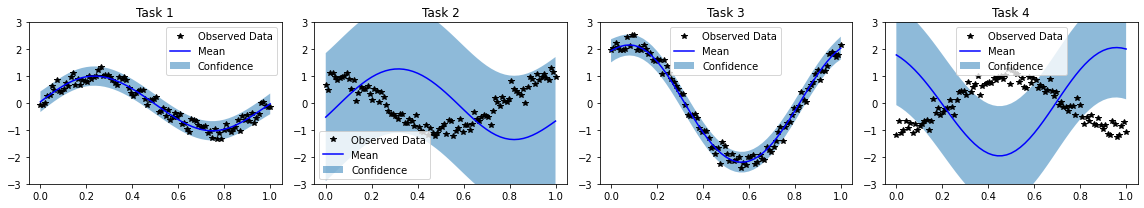

In [41]:
model.eval()
likelihood.eval()
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None